In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from football_sim import *
plt.rcParams['figure.figsize']=[32,18]

In [2]:
urls = {'EN': 'http://www.football-data.co.uk/mmz4281/1718/E0.csv',
                          'ES': 'http://www.football-data.co.uk/mmz4281/1718/SP1.csv',
                          'IT': 'http://www.football-data.co.uk/mmz4281/1718/I1.csv',
                          'FR': 'http://www.football-data.co.uk/mmz4281/1718/F1.csv',
                          'DE': 'http://www.football-data.co.uk/mmz4281/1718/D1.csv',
                          'NL': 'http://www.football-data.co.uk/mmz4281/1718/N1.csv'
                          }
urls = {'EN': 'http://www.football-data.co.uk/mmz4281/1718/E0.csv',
                          'ES': 'http://www.football-data.co.uk/mmz4281/1718/SP1.csv'}

In [3]:
all_data=get_data(urls)

In [4]:
teams = create_teams(all_data)

In [5]:
teams=calibrate(teams,all_data)

In [5]:
EnglishTeams={x:teams[x] for x in teams if teams[x].country=='EN'}
PremierLeague=Season(EnglishTeams)
PremierLeague.process_current_results(all_data['EN'])
PremierLeague.simulate_season(n_scenarios=100000)

Arsenal Leicester
Brighton Man City
Chelsea Burnley
Crystal Palace Huddersfield
Everton Stoke
Southampton Swansea
Watford Liverpool
West Brom Bournemouth
Man United West Ham
Newcastle Tottenham
Bournemouth Watford
Burnley West Brom
Leicester Brighton
Liverpool Crystal Palace
Southampton West Ham
Stoke Arsenal
Swansea Man United
Huddersfield Newcastle
Tottenham Chelsea
Man City Everton
Bournemouth Man City
Crystal Palace Swansea
Huddersfield Southampton
Man United Leicester
Newcastle West Ham
Watford Brighton
Chelsea Everton
Liverpool Arsenal
Tottenham Burnley
West Brom Stoke
Arsenal Bournemouth
Brighton West Brom
Everton Tottenham
Leicester Chelsea
Man City Liverpool
Southampton Watford
Stoke Man United
Burnley Crystal Palace
Swansea Newcastle
West Ham Huddersfield
Bournemouth Brighton
Crystal Palace Southampton
Huddersfield Leicester
Liverpool Burnley
Newcastle Stoke
Tottenham Swansea
Watford Man City
West Brom West Ham
Chelsea Arsenal
Man United Everton
Burnley Huddersfield
Everton B

In [6]:
PremierLeague.season_report()

simulation not yet processed, processing


,Points (mean),Points (low),Points (high),Win,CL,Off,Deff,Degr
Man City,86.4,77.0,96.0,94.76,100.00,2.5,2.5,0.00
Man United,73.4,64.0,83.0,3.77,91.36,2.5,2.5,0.00
Chelsea,68.9,59.0,79.0,0.82,68.54,2.5,2.5,0.00
Liverpool,68.4,59.0,78.0,0.41,67.10,2.5,2.5,0.00
Tottenham,66.4,57.0,76.0,0.22,50.68,2.5,2.5,0.00
Arsenal,62.4,53.0,72.0,0.02,21.07,2.5,2.5,0.00
Burnley,53.5,44.0,63.0,0.00,0.68,2.5,2.5,0.40
Leicester,52.4,43.0,62.0,0.00,0.47,2.5,2.5,0.62
Everton,48.5,39.0,58.0,0.00,0.03,2.5,2.5,5.02
Bournemouth,48.4,39.0,58.0,0.00,0.05,2.5,2.5,4.64


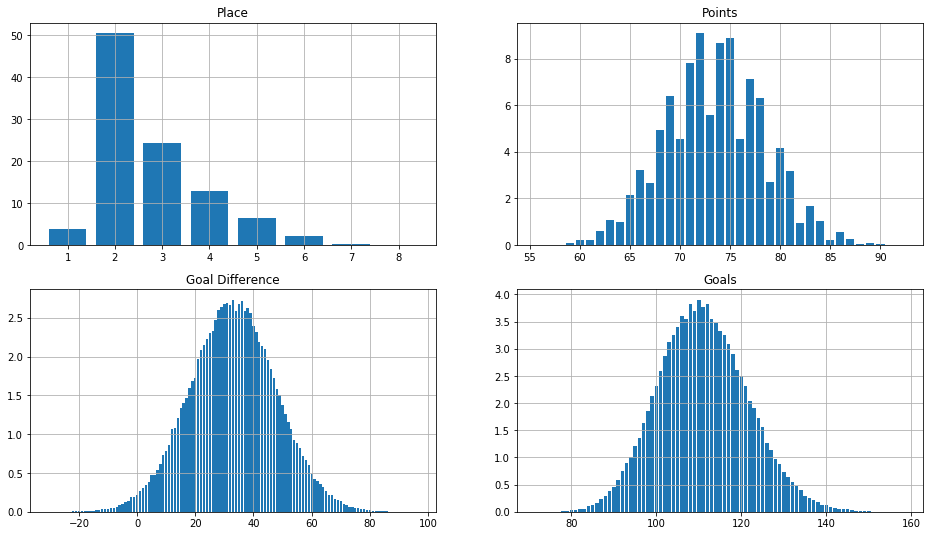

In [7]:
PremierLeague.team_report('Man United')

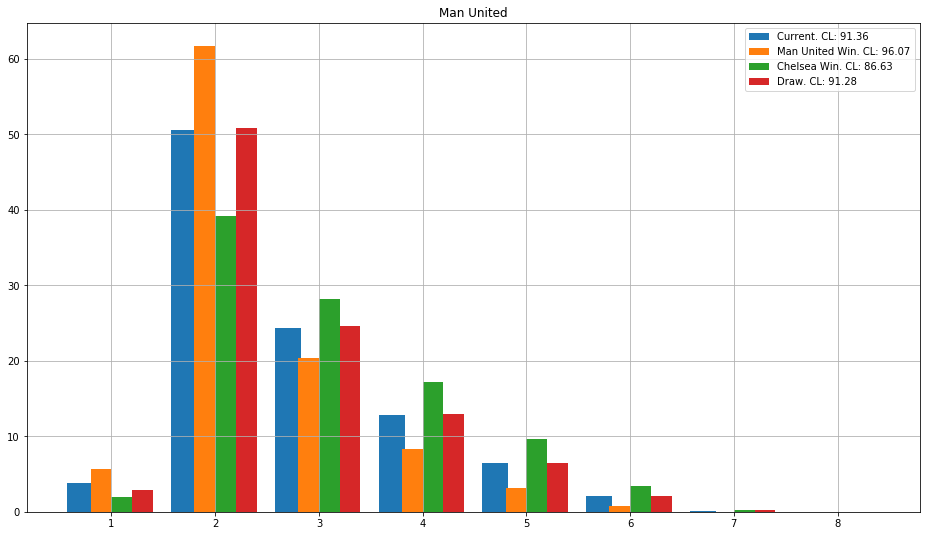

In [8]:
PremierLeague.what_if('Man United v Chelsea',ref_team='Man United')

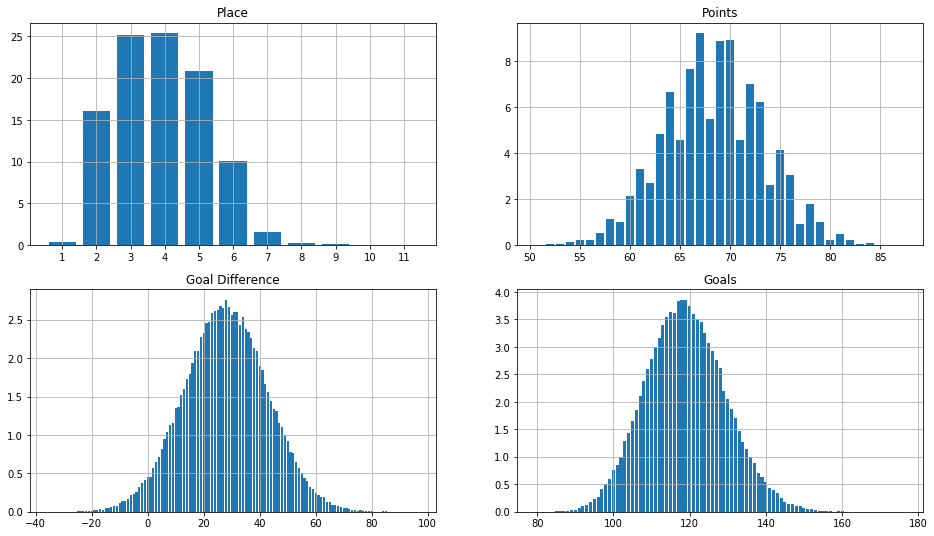

In [9]:
PremierLeague.team_report('Liverpool')

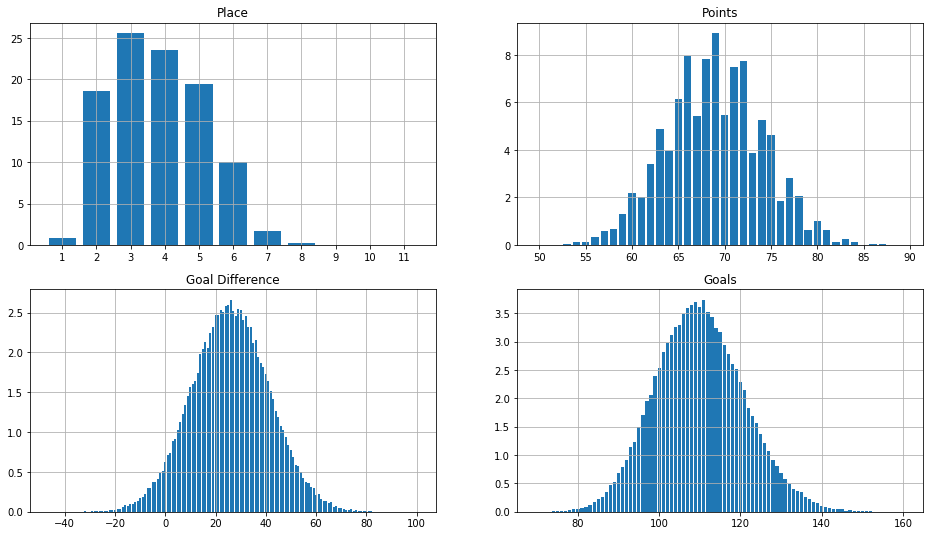

In [10]:
PremierLeague.team_report('Chelsea')

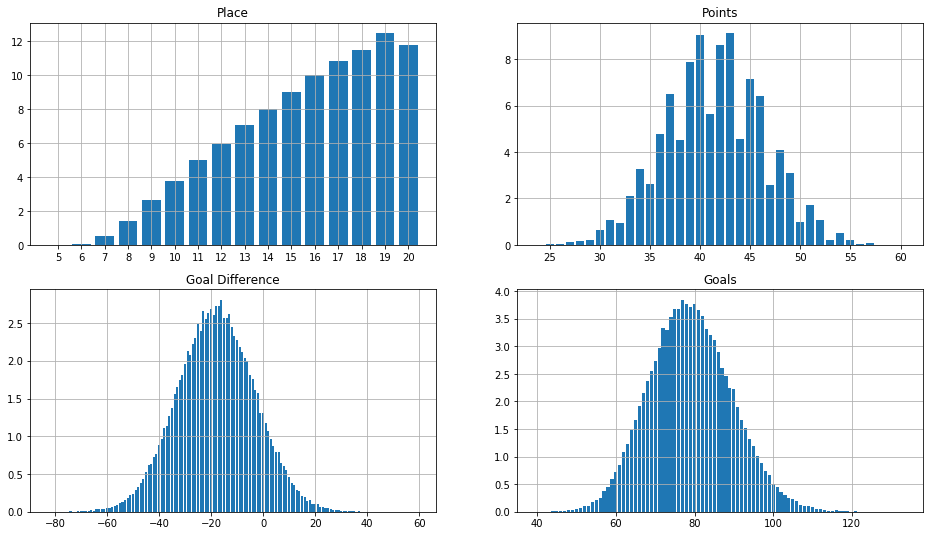

In [11]:
PremierLeague.team_report('Swansea')

In [12]:
GoodTeams={x:teams[x] for x in teams if teams[x].means()[0]>=1 }

In [13]:
GoodLeague=Season(GoodTeams)
GoodLeague.process_current_results(all_data['EN'])
GoodLeague.process_current_results(all_data['ES'])
#GoodLeague.process_current_results(all_data['DE'])
#GoodLeague.process_current_results(all_data['NL'])
#GoodLeague.process_current_results(all_data['FR'])
#GoodLeague.process_current_results(all_data['IT'])


Arsenal Leicester
Brighton Man City
Chelsea Burnley
Crystal Palace Huddersfield
Everton Stoke
Southampton Swansea
Watford Liverpool
West Brom Bournemouth
Man United West Ham
Newcastle Tottenham
Bournemouth Watford
Burnley West Brom
Leicester Brighton
Liverpool Crystal Palace
Southampton West Ham
Stoke Arsenal
Swansea Man United
Huddersfield Newcastle
Tottenham Chelsea
Man City Everton
Bournemouth Man City
Crystal Palace Swansea
Huddersfield Southampton
Man United Leicester
Newcastle West Ham
Watford Brighton
Chelsea Everton
Liverpool Arsenal
Tottenham Burnley
West Brom Stoke
Arsenal Bournemouth
Brighton West Brom
Everton Tottenham
Leicester Chelsea
Man City Liverpool
Southampton Watford
Stoke Man United
Burnley Crystal Palace
Swansea Newcastle
West Ham Huddersfield
Bournemouth Brighton
Crystal Palace Southampton
Huddersfield Leicester
Liverpool Burnley
Newcastle Stoke
Tottenham Swansea
Watford Man City
West Brom West Ham
Chelsea Arsenal
Man United Everton
Burnley Huddersfield
Everton B

56

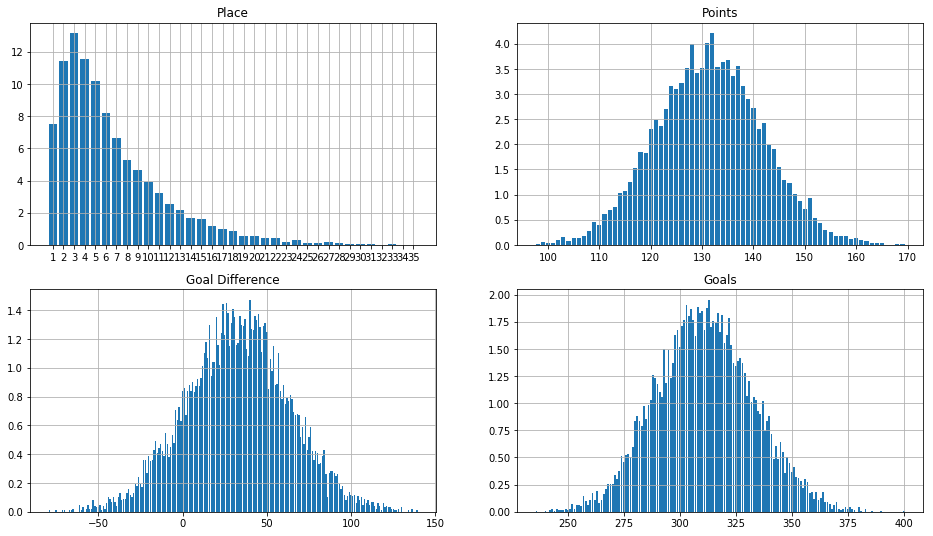

In [13]:
GoodLeague.team_report('Man United')
GoodLeague.current_points['Man United']

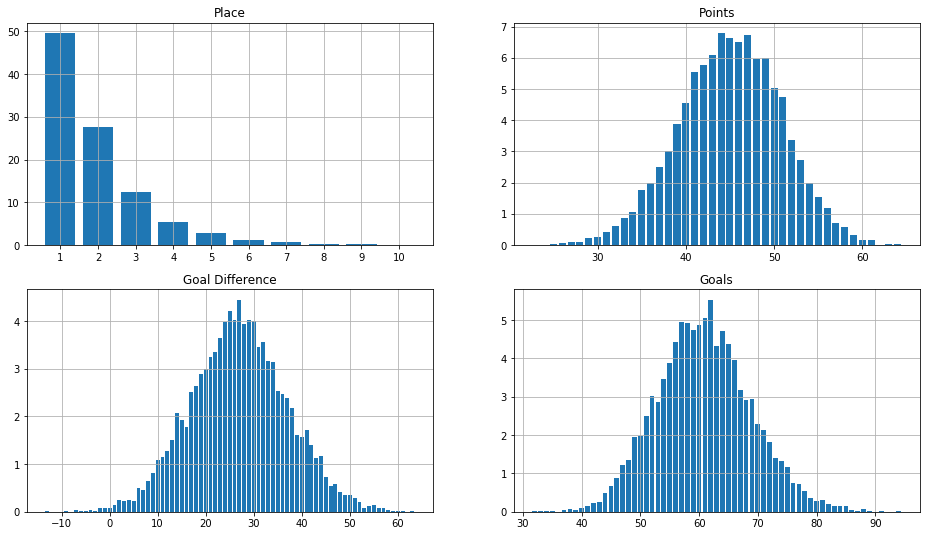

In [20]:
GoodLeague.team_report('Man City')

In [15]:
GoodLeague.season_report()

simulation not yet done, simulating
simulation not yet processed, processing


,Points (mean),Points (low),Points (high),Win,CL,Off,Deff,Degr
Man City,144.3,124.0,165.0,44.73,86.16,2.5,2.5,0.00
Barcelona,139.4,118.0,161.0,26.04,72.77,2.5,2.5,0.00
Man United,131.6,111.0,152.0,7.80,43.90,2.5,2.5,0.00
Ath Madrid,130.4,109.0,151.0,6.93,40.16,2.5,2.5,0.01
Chelsea,127.0,107.0,147.0,3.33,27.20,2.5,2.5,0.01
Liverpool,126.3,106.0,147.0,3.24,25.86,2.5,2.5,0.01
Tottenham,124.6,104.0,145.0,2.40,21.53,2.5,2.5,0.08
Real Madrid,121.9,101.0,143.0,1.60,15.97,2.5,2.5,0.19
Valencia,121.4,100.0,142.0,1.17,13.82,2.5,2.5,0.23
Arsenal,120.4,100.0,141.0,0.85,11.66,2.5,2.5,0.24


In [14]:
GoodLeague.teams

{'Alaves': <football_sim.Team at 0x7f8dabeed240>,
 'Arsenal': <football_sim.Team at 0x7f8dabededa0>,
 'Ath Bilbao': <football_sim.Team at 0x7f8dabeed320>,
 'Ath Madrid': <football_sim.Team at 0x7f8dabeed400>,
 'Barcelona': <football_sim.Team at 0x7f8dabeed470>,
 'Betis': <football_sim.Team at 0x7f8dabeed3c8>,
 'Bournemouth': <football_sim.Team at 0x7f8dabede0b8>,
 'Brighton': <football_sim.Team at 0x7f8dabede160>,
 'Burnley': <football_sim.Team at 0x7f8dabedee48>,
 'Celta': <football_sim.Team at 0x7f8dabeed358>,
 'Chelsea': <football_sim.Team at 0x7f8dabedef60>,
 'Crystal Palace': <football_sim.Team at 0x7f8dabeded68>,
 'Eibar': <football_sim.Team at 0x7f8dabeed278>,
 'Espanol': <football_sim.Team at 0x7f8dabeed0f0>,
 'Everton': <football_sim.Team at 0x7f8dabede080>,
 'Getafe': <football_sim.Team at 0x7f8dabeed438>,
 'Girona': <football_sim.Team at 0x7f8dabeed0b8>,
 'Huddersfield': <football_sim.Team at 0x7f8dabedee80>,
 'La Coruna': <football_sim.Team at 0x7f8dabeed198>,
 'Las Palmas'